<a href="https://colab.research.google.com/github/xRomory/CCMACLRL_COM231ML_PROJECT/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection using Naive Bayes and Logistic Regresssion

Import Python Libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


## Datasets

In [57]:
fake_url = "https://github.com/xRomory/CCMACLRL_COM231ML_PROJECT/blob/main/fake_news/datasets/fake_compressed.csv?raw=true"
fake_data = pd.read_csv(fake_url)

fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [58]:
true_url = "https://github.com/xRomory/CCMACLRL_COM231ML_PROJECT/blob/main/fake_news/datasets/true_compressed.csv?raw=true"
true_data = pd.read_csv(true_url)

true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [59]:
# Combine Both .csv file and add a label to classify real news and fake news dataset

fake_data["Label"], true_data["Label"] = "F", "R"

data = pd.concat([fake_data, true_data], axis=0)
data.head()

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",F
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",F
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",F
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",F
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",F


### Find out what's in the data

In [60]:
data.shape

(44898, 5)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   Label    44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [62]:
data.describe(include=["object"]).T

,count,unique,top,freq
title,44898,38729,Factbox: Trump fills top jobs for his administ...,14
text,44898,38646,,627
subject,44898,8,politicsNews,11272
date,44898,2397,"December 20, 2017",182
Label,44898,2,F,23481


Check for any missing and duplicated values

In [63]:
# Check for missing values
data.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [64]:
#Check for duplicate values
data.duplicated().sum()

np.int64(209)

In [65]:
#See all instances of duplicated rows
data[data.duplicated(keep=False)]

,title,text,subject,date,Label
9941,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",F
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017",F
11445,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",F
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017",F
14924,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015",F
...,...,...,...,...,...
21290,"Europeans, Africans agree renewed push to tack...",PARIS (Reuters) - Europe s big four continen...,worldnews,"August 28, 2017",R
21345,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",R
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017",R
21406,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",R


In [66]:
# Get value counts of Label
data.Label.value_counts()

Label
F    23481
R    21417
Name: count, dtype: int64

### Data Visualization

See the ratio of news subjects inside the datasets

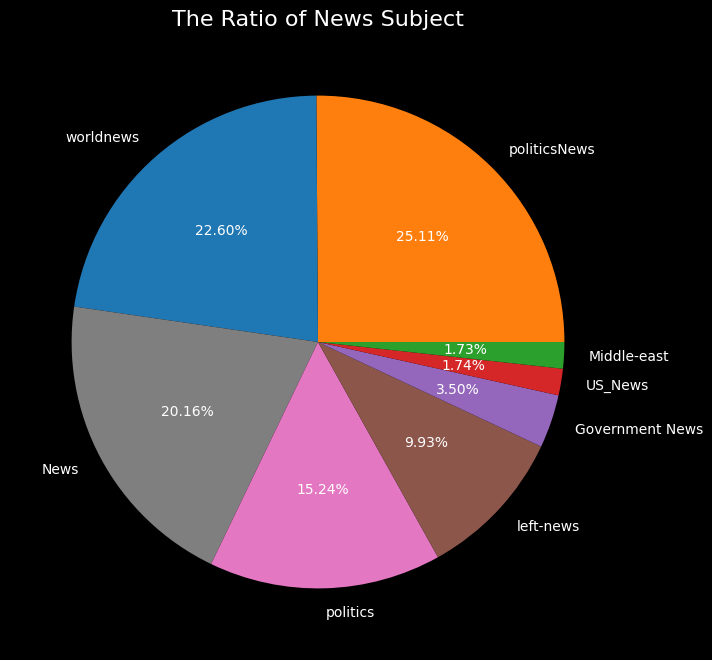

In [67]:
# Color of Pie chart
color_map = {
    "worldnews": "#1f77b4",
    "politicsNews": "#ff7f0e",
    "Middle-east": "#2ca02c",
    "US_News": "#d62728",
    "Government News": "#9467bd",
    "left-news": "#8c564b",
    "politics": "#e377c2",
    "News": "#7f7f7f"
}

subject_count = data["subject"].value_counts()
labels = subject_count.index.to_list()

colors = [color_map[label] for label in labels]
plt.style.use("dark_background")
plt.figure(figsize=(8, 8))
plt.pie(
    x=subject_count,
    autopct="%1.2f%%",
    labels=labels,
    colors=colors,
)
plt.title("The Ratio of News Subject", fontsize=16)
plt.show()

See target distribution of our data:

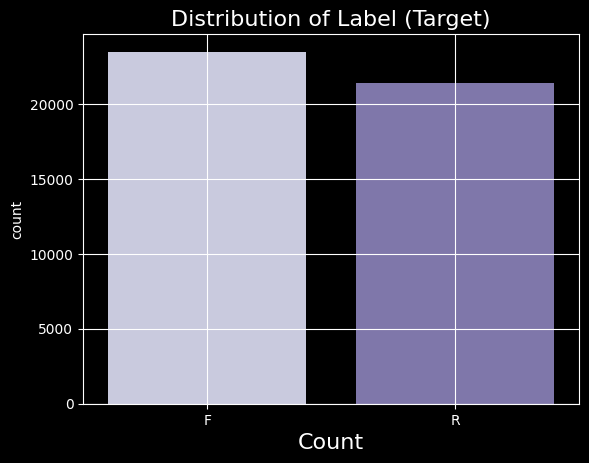

In [68]:
sns.countplot(x=data.Label, data=data, palette="Purples", hue="Label")
plt.title("Distribution of Label (Target)", fontsize=16)
plt.xlabel("Target", fontsize=16)
plt.xlabel("Count", fontsize=16)
plt.grid(True)
plt.show()

See subject counts inside our datasets (Fake, and Real).

In [69]:
data_counts = data.groupby(["subject", "Label"]).size().unstack(fill_value=0)
data_counts

Label,F,R
subject,,
Government News,1570,0
Middle-east,778,0
News,9050,0
US_News,783,0
left-news,4459,0
politics,6841,0
politicsNews,0,11272
worldnews,0,10145


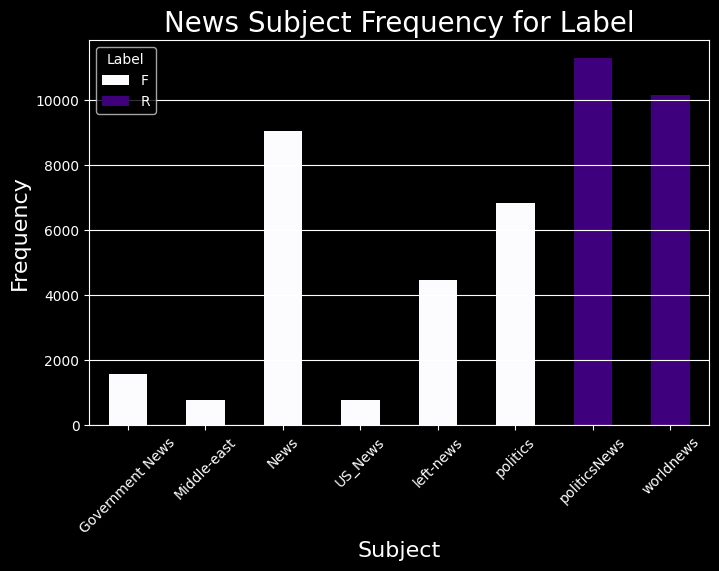

In [70]:
plt.figure(figsize=(8, 5))
data_counts.plot(
    kind="bar",
    stacked=True,
    colormap="Purples",
    ax=plt.gca()
)
plt.title("News Subject Frequency for Label", fontsize=20)
plt.xlabel("Subject", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.show()

See frequent words used in our datasets

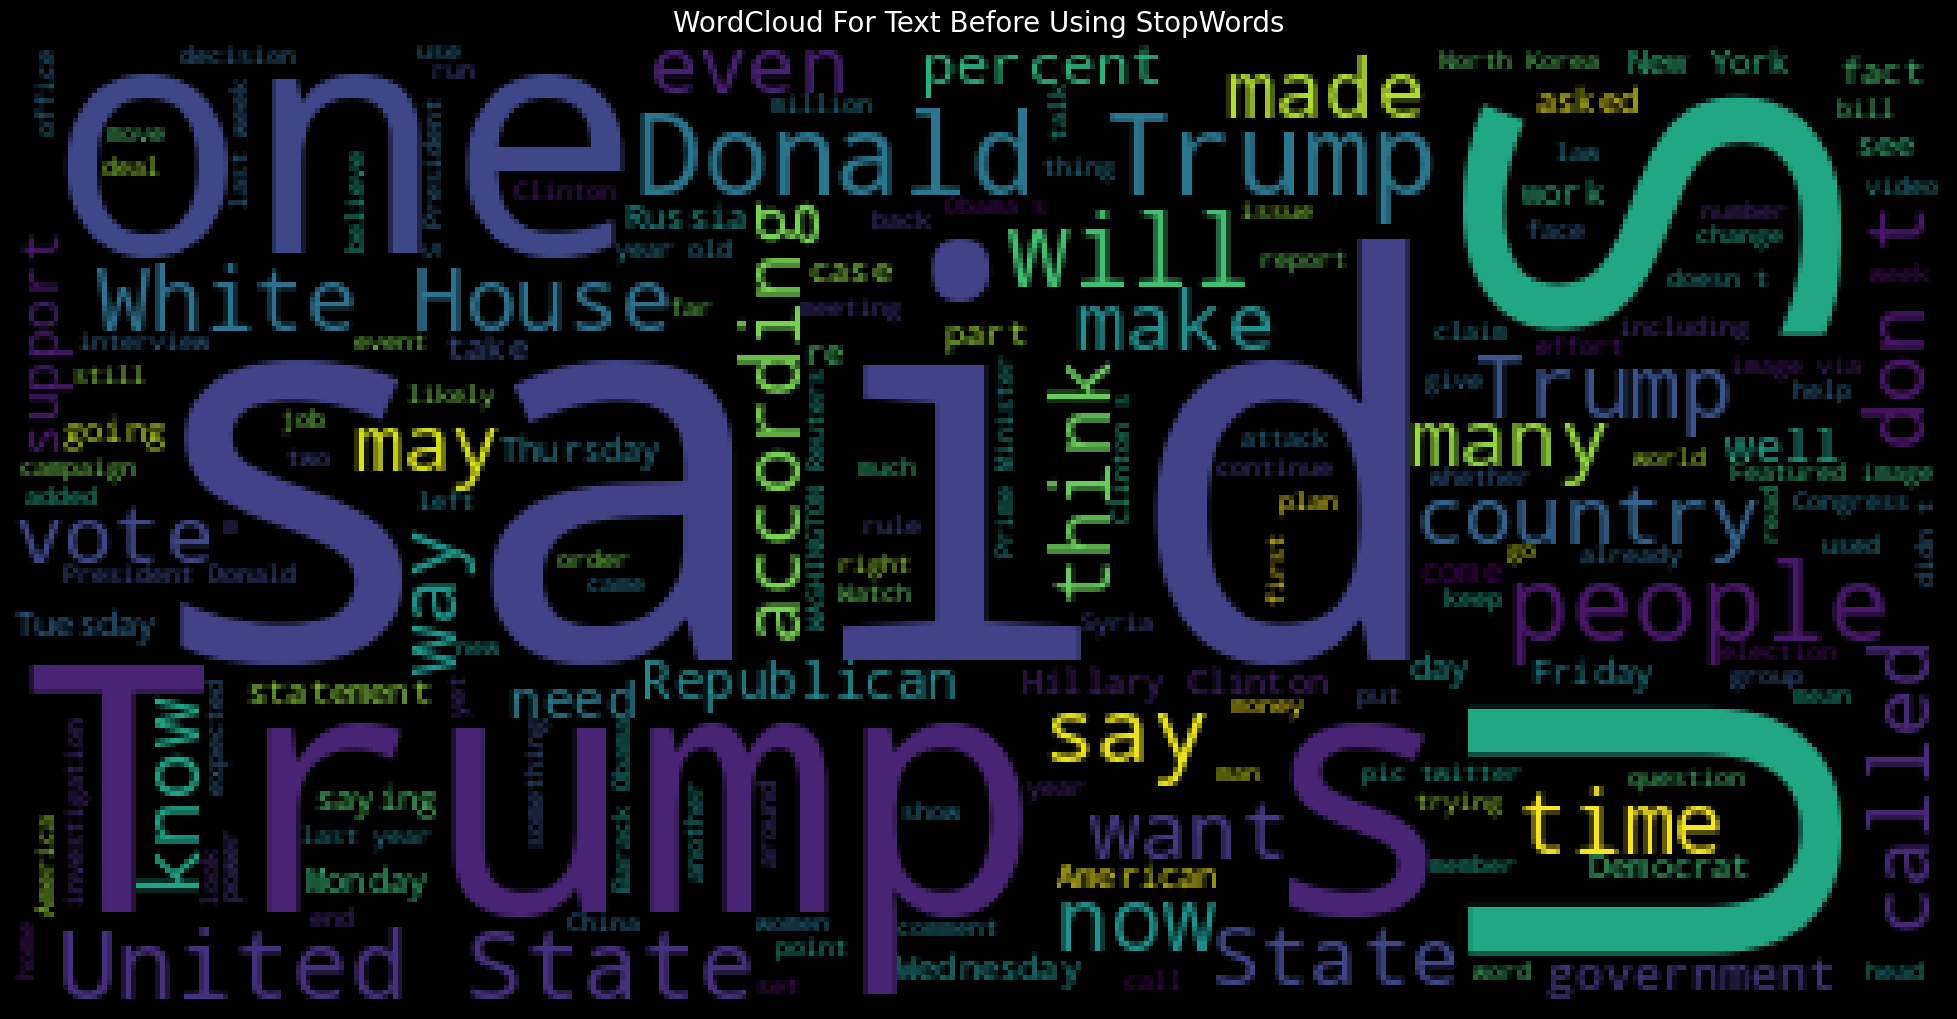

In [71]:
plt.figure(figsize=(25, 15))
plt.imshow(WordCloud(background_color='black').generate(" ".join(data.text)))
plt.axis("off")
plt.title("WordCloud For Text Before Using StopWords", fontsize=20)
plt.show()

### Data pre-processing

A while ago, we noticed that we have duplicated values. So, what we can do is drop them.

In [72]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

np.int64(0)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   Label    44689 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


Use stopwords to exclude common words

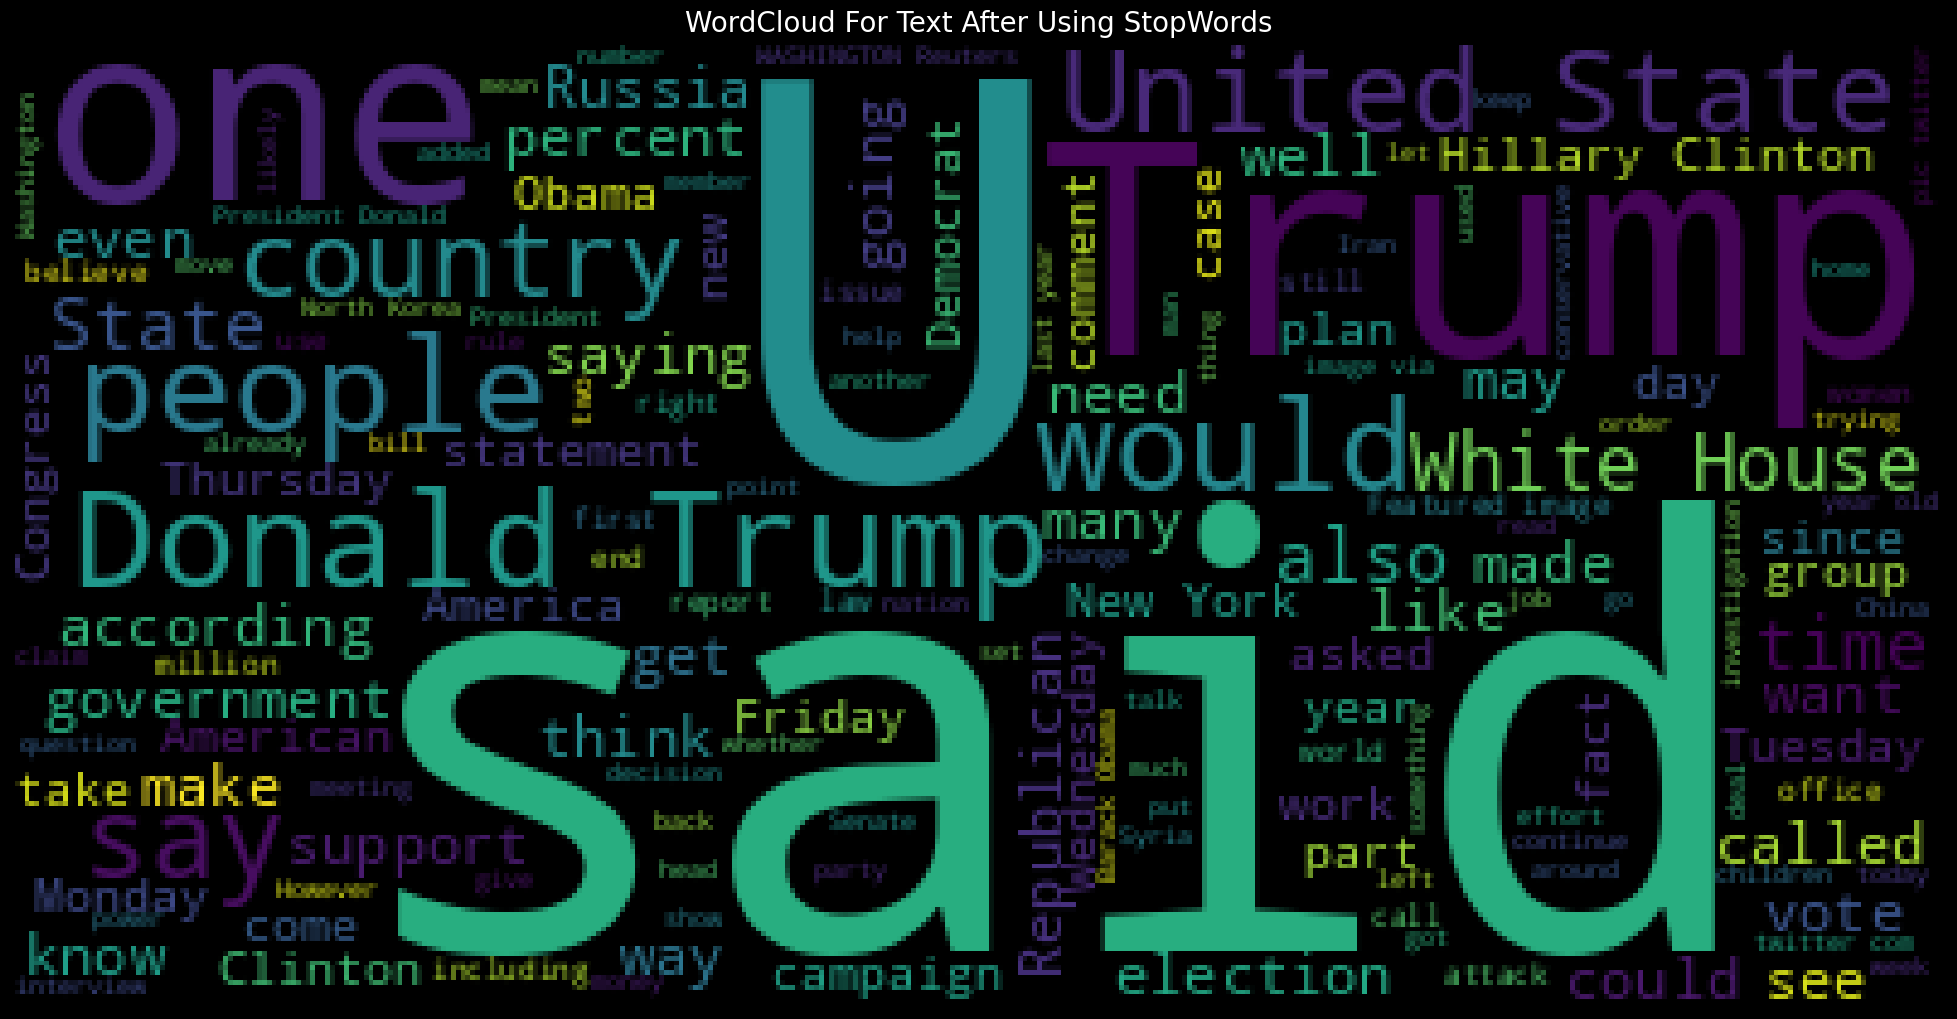

In [74]:
plt.figure(figsize=(25, 15))
plt.imshow(
    WordCloud(
        background_color='black',
        stopwords=set(stopwords.words('english'))
    ).generate(" ".join(data.text))
)
plt.axis("off")
plt.title("WordCloud For Text After Using StopWords", fontsize=20)
plt.show()

See data text in our datasets

In [75]:
data_text = data.text
data_text

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
21412    BRUSSELS (Reuters) - NATO allies on Tuesday we...
21413    LONDON (Reuters) - LexisNexis, a provider of l...
21414    MINSK (Reuters) - In the shadow of disused Sov...
21415    MOSCOW (Reuters) - Vatican Secretary of State ...
21416    JAKARTA (Reuters) - Indonesia will buy 11 Sukh...
Name: text, Length: 44689, dtype: object

In [76]:
import re
def normalize_text(text):
    # Remove X user handle starting with "@"
    text=re.sub(r'@\w+', '', text)
    
    # Remove non-alphanumeric characters and extra whitespaces
    text=re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove multiple whitespaces
    text=re.sub(r'\s+', ' ', text)
    
    # Convert data text to lowercase
    text = text.lower()
    
    return text

In [77]:
data_text = data_text.apply(normalize_text)
data_text

0        donald trump just couldn t wish all americans ...
1        house intelligence committee chairman devin nu...
2        on friday it was revealed that former milwauke...
3        on christmas day donald trump announced that h...
4        pope francis used his annual christmas day mes...
                               ...                        
21412    brussels reuters nato allies on tuesday welcom...
21413    london reuters lexisnexis a provider of legal ...
21414    minsk reuters in the shadow of disused soviete...
21415    moscow reuters vatican secretary of state card...
21416    jakarta reuters indonesia will buy sukhoi figh...
Name: text, Length: 44689, dtype: object

In [78]:
data_target = data.Label
data_target

0        F
1        F
2        F
3        F
4        F
        ..
21412    R
21413    R
21414    R
21415    R
21416    R
Name: Label, Length: 44689, dtype: object

In [79]:
# Transform "R" and "F" to a numeric for easy data modeling
data_target.replace('R', 1, inplace=True)
data_target.replace('F', 0, inplace=True)
data_target

/tmp/ipykernel_4369/3018169528.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_target.replace('F', 0, inplace=True)


0        0
1        0
2        0
3        0
4        0
        ..
21412    1
21413    1
21414    1
21415    1
21416    1
Name: Label, Length: 44689, dtype: int64

In [80]:
x_train, x_test, y_train, y_test = train_test_split(
    data_text,
    data_target,
    test_size=0.2,
    random_state=42
)

print("x_train Shape:", x_train.shape)
print("x_test Shape:", x_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

x_train Shape: (35751,)
x_test Shape: (8938,)
y_train Shape: (35751,)
y_test Shape: (8938,)


#### Multinomial Naive Bayes Model

#### Logistic Regression Model

In [81]:
# Find the best parameter for LR, and TF-IDF
lr_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,1),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
    )),
    ("lr", LogisticRegression(
        C=10,
        solver='liblinear',
        random_state=44,
        max_iter=10000,
    )),
])

lr_model.fit(x_train, y_train)

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'lr__C': [0.01, 0.1, 1, 10],
#     'lr__solver': ['liblinear', 'saga'],
# }

# grid = GridSearchCV(
#     lr_model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === Output ===
# Best Parameters: {'lr__C': 10, 'lr__solver': 'liblinear', 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
# Best Cross-Validation Score: 0.9961120093722527

,steps,"[('tfidf', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


Logistic Regression Model Check

In [82]:
print("Pipeline Model Train Score:", lr_model.score(x_train, y_train))
print("Pipeline Model Test Score:", lr_model.score(x_test, y_test))


Pipeline Model Train Score: 0.9998601437722022
Pipeline Model Test Score: 0.9972029536809129


In [83]:
# lr_best_model = grid.best_estimator_

y_pred = lr_model.predict(x_test)
df = pd.DataFrame()
df["Actual"], df["Predict"] = y_test, y_pred
df.replace(1, "R", inplace=True)
df.replace(0, "F", inplace=True)
df

,Actual,Predict
17896,F,F
16186,R,R
12959,R,R
21764,F,F
7557,F,F
...,...,...
16296,F,F
4455,R,R
13633,F,F
9704,R,R


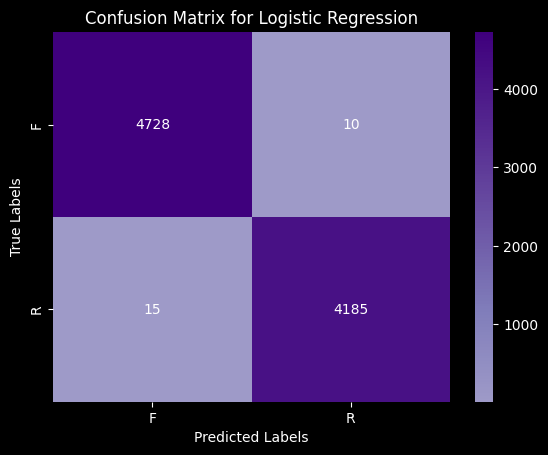

array([[4728,   10],
       [  15, 4185]])

In [84]:
c_matrix = confusion_matrix(y_test, y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True, 
    cmap='Purples',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()
c_matrix

In [85]:
lr_classification_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report of Logistic Regression\n", lr_classification_report)

Classification Report of Logistic Regression
               precision    recall  f1-score   support

           F       1.00      1.00      1.00      4738
           R       1.00      1.00      1.00      4200

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



#### Random Tree Forest Model

In [ ]:
# Find the best parameter for RTF

# === RUN ONLY ONCE ===
# param_grid = {
#     'tfidf__max_df': [0.7, 0.8, 0.9],
#     'tfidf__ngram_range': [(1,1), (1,2)],
#     'rfc__n_estimators': [100, 300, 500],
#     'rfc__max_depth': [None, 30, 50],
#     'rfc__min_samples_split': [2, 5],
# }

# grid = GridSearchCV(
#     rf_model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid.fit(x_train, y_train)

# print("Best Parameters:", grid.best_params_)
# print("Best Cross-Validation Score:", grid.best_score_)

# === Output ===
# Best Parameters: {'rfc__max_depth': None, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 300, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 1)}
# Best Cross-Validation Score: 0.9933708210402379

In [91]:
# random_forest_model = Pipeline([
#     ('rf_model', RandomForestClassifier(criterion='gini', n_estimators=400, max_depth=600, random_state=44))
# ])

# random_forest_model.fit(x_train, y_train)
rf_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,1),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
    )),
    ("rfc", RandomForestClassifier(
        criterion='gini',
        max_depth=None,
        n_estimators=300,
        min_samples_split=2,
        random_state=44,
    )),
])

rf_model.fit(x_train, y_train)

,steps,"[('tfidf', ...), ('rfc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


Random Forest Model Check

In [92]:
print("Pipeline Model Train Score: ", rf_model.score(x_train, y_train))
print("Pipeline Model Test Score: ", rf_model.score(x_test, y_test))

Pipeline Model Train Score:  0.9999720287544405
Pipeline Model Test Score:  0.9949653166256434


In [93]:
# rfc_best_model = grid.best_estimator_
y_pred = rf_model.predict(x_test)

df = pd.DataFrame()
df["Actual"], df["Predict"] = y_test, y_pred
df.replace(1, "R", inplace=True)
df.replace(0, "F", inplace=True)
df

,Actual,Predict
17896,F,F
16186,R,R
12959,R,R
21764,F,F
7557,F,F
...,...,...
16296,F,F
4455,R,R
13633,F,F
9704,R,R


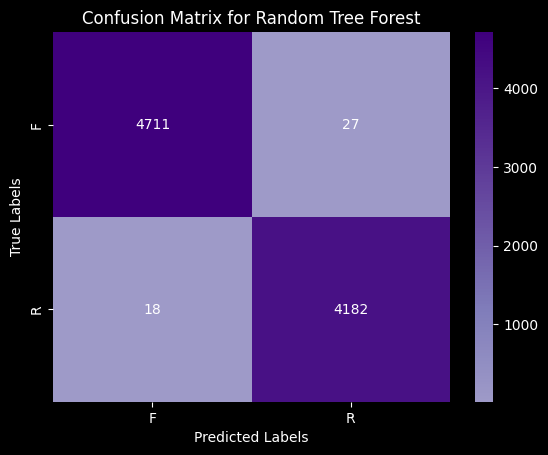

array([[4711,   27],
       [  18, 4182]])

In [94]:
c_matrix = confusion_matrix(y_test, y_pred)
target_names = ['F', 'R']
sns.heatmap(
    c_matrix,
    annot=True,
    fmt='g',
    center=True, 
    cmap='Purples',
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Random Tree Forest")
plt.show()
c_matrix

In [95]:
rf_classification_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report of Random Tree Forest\n", rf_classification_report)

Classification Report of Random Tree Forest
               precision    recall  f1-score   support

           F       1.00      0.99      1.00      4738
           R       0.99      1.00      0.99      4200

    accuracy                           0.99      8938
   macro avg       0.99      1.00      0.99      8938
weighted avg       0.99      0.99      0.99      8938

